In [1]:
import matplotlib.pylab as plt
import matplotlib

matplotlib.rcParams['font.family'] = 'Times New Roman'
import shap
import pandas as pd
import numpy as np
import pickle
plt.rcParams['font.weight'] = 'bold'  
plt.rcParams['axes.labelweight'] = 'bold'  

In [2]:
import sklearn
import shap

print(f"scikit-learn version: {sklearn.__version__}")
print(f"shap version: {shap.__version__}")


scikit-learn version: 1.2.2
shap version: 0.44.1


### Partial dependence plot (reference interval)

In [7]:
def model_proba(x):
    return model.predict_proba(x)[:,1]
def model_relative_proba(x):
    return model.predict_proba(x)[:,1]/expected_proba
def model_logodds(x):
    return model.predict(x, output_margin=True)
def model_odds(x):
    return np.exp(model.predict(x, output_margin=True))
def logodds_proba(x):
    return np.exp(x)/(1+np.exp(x))
def proba_logodds(x):
    return np.log(x/(1-x))
def odds_proba(x):
    return x/(1+x)
def logodds_odds(x):
    return np.exp(x)
def odds_logodds(x):
    return np.log(x)

In [8]:

ri_excel_path = '/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/RI.xlsx'


ri_df = pd.read_excel(ri_excel_path, sheet_name='Sheet1')

RI_dict = ri_df.set_index('Type_Short_Name')['RI_all'].to_dict()

In [9]:
print(RI_dict)

{'WBC, Low': '4-10', 'Neutrophil count, Low': '1.9-8.0', 'RBC': '4.3-5.3', 'Hb': '13-17', 'RDW': '11.5-14.5', 'PLT, High': '150-450', 'MPV': '7.4-12.1', 'PT': '11.5-14.9', 'aPTT': '28.4-44.7', 'Albumin': '3.5-5.2', 'ALP': '40-150', 'AST': '5-34', 'ALT': '0-55', 'BUN': '8.9-20.6', 'Cr': '0.72-1.25', 'total calcium, High': '8.4-10.2', 'Total Cheloesterol': '0-200', 'GGT': '12-64', 'Direct  bilirubin': '0.0-0.5', 'Total bilirubin': '0.2-1.2', 'LD': '125-220', 'Na, Low': '136-145', 'K, Low': '3.5-5.1', 'cl, Low': '98-107', 'uric acid': '2.9-7.3', 'tCO2, High': '24-31', 'protein': '6.4-8.3', 'CRP': '0-5.0'}


In [17]:
model_name = 're14'
feature = 'GGT'

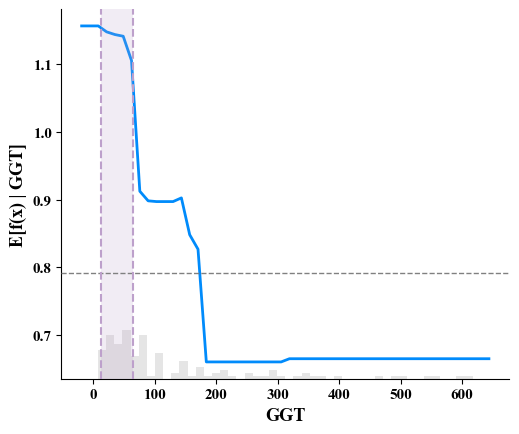

In [18]:
# Correctly extract lower and upper bounds
bounds = RI_dict[feature].split('-')
lower_bound = float(bounds[0])
upper_bound = float(bounds[1])

model = pickle.load(open('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/model.pickle.dat', "rb"))
data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')[model.get_booster().feature_names]

display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/re30/feature_list_Display_name thesis 2.xlsx')
display_col=[]
for col in data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(data.columns, display_col))

expected_proba = model_proba(data).mean()
shap.partial_dependence_plot(
        feature, model_relative_proba, data, model_expected_value=False, npoints=50, 
        feature_expected_value=False, show=False, ice=False, 
    )


plt.axhline(y=36.5, color='grey', linestyle='--', linewidth=1)

plt.subplots_adjust(left=0.2, right=0.9)  
plt.axvline(x=lower_bound, color='#BDA0CB', linestyle='--')
plt.axvline(x=upper_bound, color='#BDA0CB', linestyle='--')
plt.axvspan(lower_bound, upper_bound, color='#BDA0CB', alpha=0.2, lw=0)
# 현재 그림을 TIFF 파일로 저장
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/RI PDP plot - '+ feature +'.tiff', format='tiff', dpi=300)
plt.show()

### model comparison plot

In [5]:
def Gabe_plot_part(shap_values_A, cols_A, shap_values_B, cols_B, fea_num, Prediction_14days, Prediction_30days):
    fig = plt.figure(figsize=(9, 12))
    ax1 = fig.add_subplot(111)
    
    cols_sorted_A = cols_A[np.argsort(-np.sum(np.abs(shap_values_A), axis=0))]
    cols_sorted_B = cols_B[np.argsort(-np.sum(np.abs(shap_values_B), axis=0))]
    
    cols_sorted_A = list(cols_sorted_A[0:fea_num][::-1])
    cols_sorted_B = list(cols_sorted_B[0:fea_num][::-1])
    print('top 30 of left', cols_sorted_A[-12])
    print('top 30 of right', cols_sorted_B[-12])
    
    display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/re30/feature_list_Display_name thesis 2.xlsx')
    
    print('A top 30 features:')
    for i in range(len(cols_sorted_A)):
        cols_sorted_A[i] = (list(display_name.loc[display_name['Type_Short_Name']==cols_sorted_A[i], 'Display_Name'])[0])
    for i in range(len(cols_sorted_A)):
        print(cols_sorted_A[len(cols_sorted_A)-i-1])
    print('\nB top 30 features:')
    for i in range(len(cols_sorted_B)):
        cols_sorted_B[i] = (list(display_name.loc[display_name['Type_Short_Name']==cols_sorted_B[i], 'Display_Name'])[0])
    for i in range(len(cols_sorted_B)):
        print(cols_sorted_B[len(cols_sorted_B)-i-1])
    
    dict_A = dict(zip(cols_sorted_A, [i+1 for i in range(1, fea_num+1)]))
    dict_B = dict(zip(cols_sorted_B, [i+1 for i in range(1, fea_num+1)]))
    cols_sorted_A.insert(0, 'Other features')
    cols_sorted_B.insert(0, 'Other features')
    cols_sorted_A.append('')
    cols_sorted_B.append('')

    col_list = set(dict_A.keys()) | set(dict_B.keys())
    print(col_list)
    for col in col_list:
        if col in dict_A.keys():
            if dict_A[col]>=(fea_num-28): #20-2
                if col not in dict_B.keys():
                    ax1.plot([0.01,.99], [dict_A[col], 1], alpha=.5, c='#ff0255') #red
                elif dict_B[col]>=(fea_num-28):
                    ax1.plot([0.01,.99], [dict_A[col], dict_B[col]], alpha=.5, c='#8c7ae6') #purple
                else:
                    ax1.plot([0.01,.99], [dict_A[col], dict_B[col]], alpha=.5, c='#ff0255') #red
            else:
                if col in dict_B.keys():
                    if dict_B[col]>=(fea_num-28):
                        ax1.plot([0.01,.99], [dict_A[col], dict_B[col]], alpha=.5, c='#018ae7') #blue
        else:
            if dict_B[col]>=(fea_num-28):
                ax1.plot([0.01,.99], [1, dict_B[col]], alpha=.5, c='#018ae7') #blue
    
    fontsize=9
    ax1.set_ylabel(Prediction_14days)
    ax1.set_ylim(0, fea_num+1)
    ax1.set_xlim(0, 1)
    ax1.set_yticks([i for i in range(1, fea_num+3)])
    ax1.set_yticklabels(cols_sorted_A, fontsize=fontsize)
    ax1.get_xaxis().set_visible(False)

    ax2 = ax1.twinx()  
    ax2.set_ylabel(Prediction_30days)
    ax2.set_ylim(0, fea_num+1)
    ax2.set_yticks([i for i in range(1, fea_num+3)])
    ax2.set_yticklabels(cols_sorted_B, fontsize=fontsize)

top 30 of left RBC
top 30 of right PT
A top 30 features:


IndexError: list index out of range

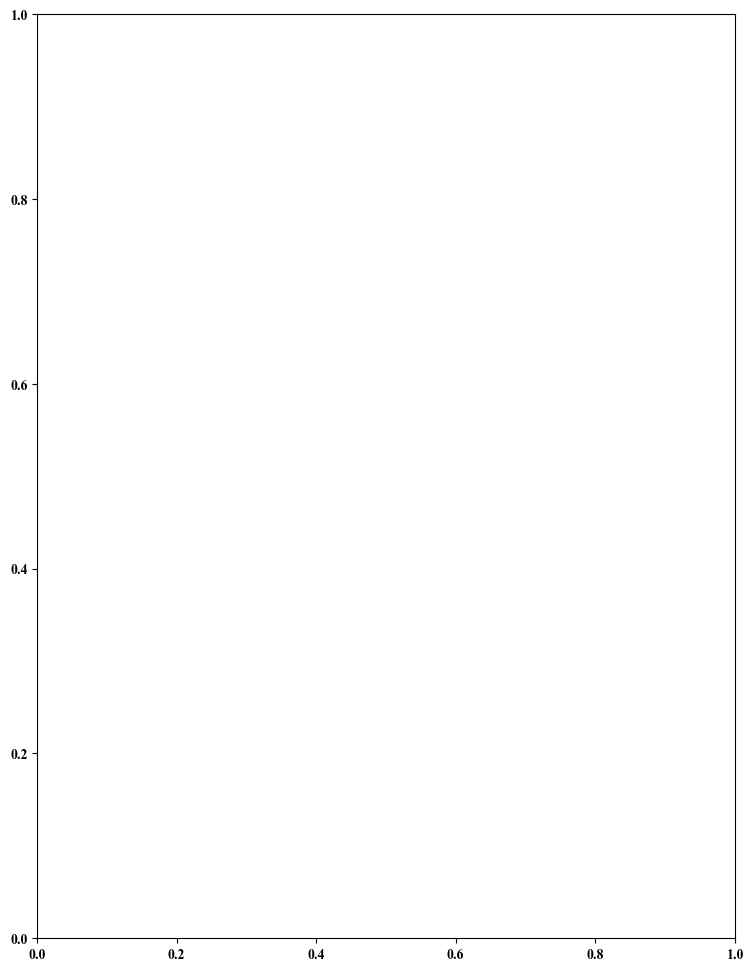

In [6]:
left_model = 'after30'
right_model = 're30'
X_left = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+left_model+'/fore_data.xlsx')
X_right = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+right_model+'/fore_data.xlsx')
tree_shap_values_left = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+left_model+'/shap_values.npy')
tree_shap_values_right = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+right_model+'/shap_values.npy')
Gabe_plot_part(tree_shap_values_left, X_left.columns, tree_shap_values_right, X_right.columns, 12, '30', '14')
plt.subplots_adjust(left=0.4, right=0.7)  # left와 right 값을 조정해보세요
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+left_model+'/gabe plot.tiff', format='tiff', dpi=300)
plt.show()

### SHAP summary plot

In [3]:
model_name = 're14'

In [4]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/feature_list_Display_name Thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
feature_ranking = np.argsort(mean_abs_shap_values)[::-1]  # Descending order


shap_values_to_plot = shap_values[:, indices_to_plot]
fore_data_to_plot = fore_data[features_to_plot]

# Plot the SHAP summary plot for the selected features
shap.summary_plot(shap_values_to_plot, fore_data_to_plot, show=False)

# Save the plot as a TIFF file
plt.savefig(f'/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/{model_name}/shap_summary_plot_selected.tiff', format='tiff', dpi=300)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/re14/feature_list_Display_name Thesis 2.xlsx'

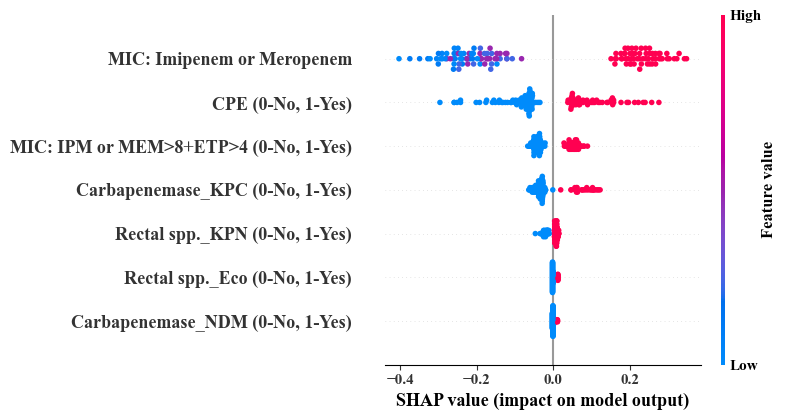

In [5]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/re30/feature_list_Display_name Thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

# Rename columns
fore_data = fore_data.rename(columns=col_dict)

# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
feature_ranking = np.argsort(mean_abs_shap_values)[::-1]  # Descending order

# Define the feature ranks you want to plot
ranks_to_plot = [6, 18, 31, 32, 53, 73, 78]
indices_to_plot = [feature_ranking[i-1] for i in ranks_to_plot]
features_to_plot = fore_data.columns[indices_to_plot]

# Filter SHAP values and fore_data
shap_values_to_plot = shap_values[:, indices_to_plot]
fore_data_to_plot = fore_data[features_to_plot]

# Plot the SHAP summary plot for the selected features
shap.summary_plot(shap_values_to_plot, fore_data_to_plot, show=False)

# Save the plot as a TIFF file
plt.savefig(f'/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/{model_name}/shap_summary_plot_micro14.tiff', format='tiff', dpi=300)
plt.show()

In [19]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/feature_list_Display_name Score14.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)
shap.plots.beeswarm(shap_values, fore_data, color=plt.get_cmap("cool"))
# 현재 그림을 TIFF 파일로 저장
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap summary plot 15.tiff', format='tiff', dpi=300)
plt.show()

TypeError: The beeswarm plot requires an `Explanation` object as the `shap_values` argument.

In [158]:
model_name = 're14'

not enough data in bin #8 for feature CCI score, so it'll be ignored. Try increasing the number of records to plot.


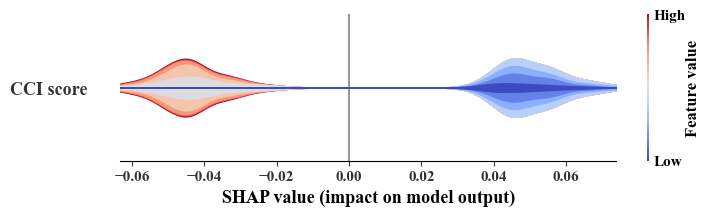

In [159]:

# 데이터와 SHAP 값 로드
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_values.npy')

# Display 이름 로드 및 매핑
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/CRE30/feature_list_Display_name thesis 2.xlsx')
display_col = [display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'].values[0] for col in fore_data.columns]
col_dict = dict(zip(fore_data.columns, display_col))
fore_data = fore_data.rename(columns=col_dict)

# 특정 피처 선택
selected_feature_index = 11
selected_feature_name = list(col_dict.values())[selected_feature_index]
selected_shap_values = shap_values[:, selected_feature_index]
selected_features = fore_data.iloc[:, selected_feature_index]

# 바이올린 플롯 생성
plt.figure(figsize=(10, 6)) 
shap.plots.violin(
    selected_shap_values.reshape(-1, 1),
    features=selected_features.values.reshape(-1, 1),
    feature_names=[selected_feature_name],
    plot_type="layered_violin", show=False
)

# TIFF 파일로 저장하기 전에 플롯 보여주기
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap s.tiff', format='tiff', dpi=300)

# 그림 보여주기
plt.show()


### SHAP values plot

In [9]:
model_name = 're30'
feature = 'PT'

<Figure size 640x480 with 0 Axes>

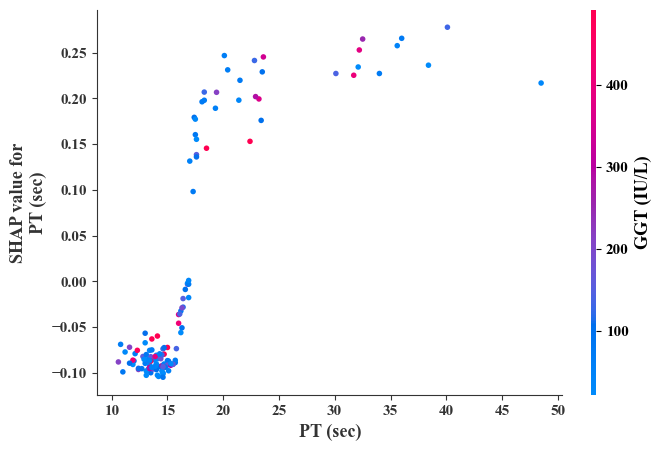

In [10]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/re30/feature_list_Display_name thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)
plt.subplots_adjust(left=0.2, right=0.9)  # left와 right 값을 조정해보세요
shap.dependence_plot(col_dict[feature], shap_values, fore_data, show=False, feature_names=display_col, interaction_index=col_dict['GGT'])
# 현재 그림을 TIFF 파일로 저장
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap values plot-'+feature+'.tiff', format='tiff', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

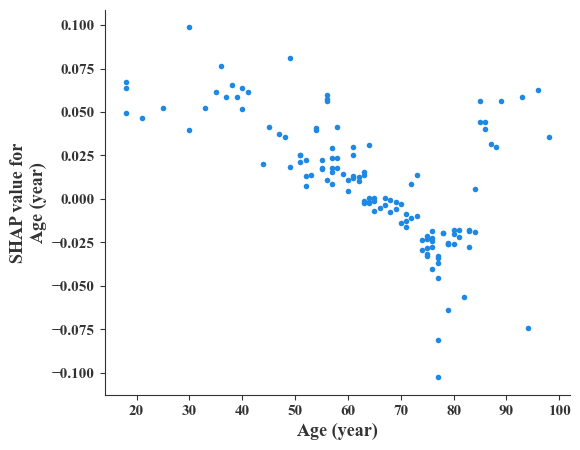

In [163]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/re30/feature_list_Display_name thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)
plt.subplots_adjust(left=0.2, right=0.9)  # left와 right 값을 조정해보세요
shap.dependence_plot(col_dict[feature], shap_values, fore_data, show=False, feature_names=display_col, interaction_index=None)
# 현재 그림을 TIFF 파일로 저장
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap values plot-age.tiff', format='tiff', dpi=300)
plt.show()

SHAP value plot sol

In [2]:
model_name = 're30'
feature = 'HTN_1'

In [3]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/re30/feature_list_Display_name thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)

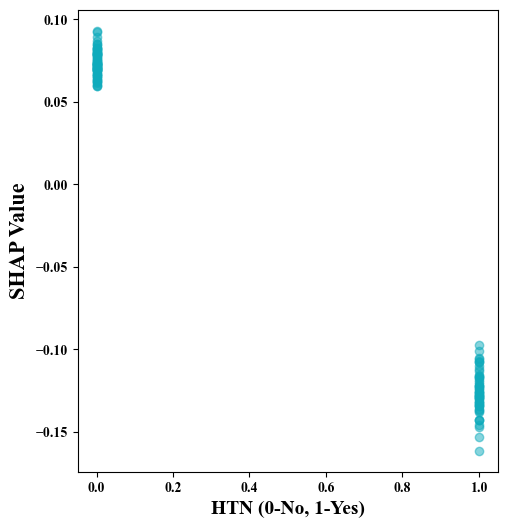

In [4]:

feature_display_name = col_dict[feature]

feature_values = fore_data[feature_display_name]  
shap_values_for_feature = shap_values[:, fore_data.columns.get_loc(feature_display_name)]  


plt.figure(figsize=(6, 6))
plt.scatter(feature_values, shap_values_for_feature, c='#0fabbc', alpha=0.5)  
plt.xlabel(feature_display_name, fontsize=14)
plt.ylabel('SHAP Value', fontsize=16)



# 그림 저장하기 전에 left와 right 값을 조정
plt.subplots_adjust(left=0.2, right=0.9)

# 현재 그림을 TIFF 파일로 저장
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap values sol plot-Age.tiff', format='tiff', dpi=300)
plt.show()

In [35]:

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(fore_data) 


explanation = shap.Explanation(values=shap_values[feature,:],
                               base_values=explainer.expected_value,
                               data=fore_data.iloc[feature,:],
                               feature_names=display_col)


plt.figure(figsize=(12, 14))
shap.plots.scatter(explanation, show=False)


plt.savefig('solMICplot.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()




IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
model_name = 're14'
feature = 'MIC: IMP or MPM'

In [ ]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/re30/feature_list_Display_name thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)

### SHAP main effect plot

In [9]:
model_name = 're14'
feature = 'MIC: IMP or MPM'

<Figure size 1000x600 with 0 Axes>

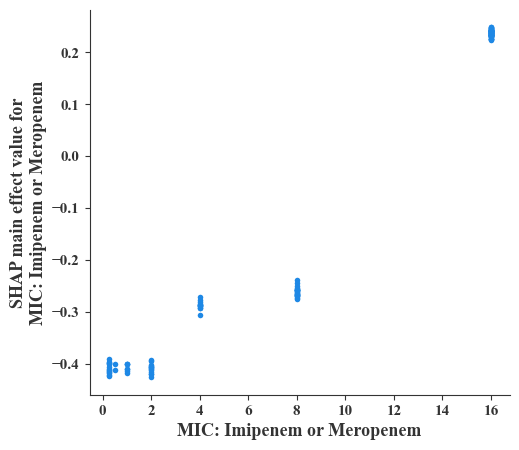

In [10]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_inter_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_interaction_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/re30/feature_list_Display_name thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)

plt.figure(figsize=(10, 6)) 
shap.dependence_plot((col_dict[feature], col_dict[feature]), shap_inter_values, fore_data, show=False, feature_names=display_col, interaction_index=None)

plt.subplots_adjust(left=0.2, right=0.9) 
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap main effect plot-MIC.tiff', format='tiff', dpi=300)
plt.show()

Text(15.58, 1.0, '15.58')

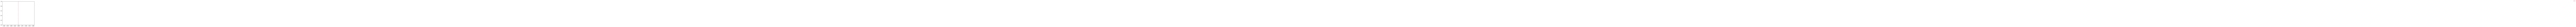

In [74]:
plt.axvline(x=-2, color='#EA6176', linestyle='--')
plt.text(15.58, plt.gca().get_ylim()[1], '15.58', color='#EA6176', horizontalalignment='right', verticalalignment='bottom')

<Figure size 1000x600 with 0 Axes>

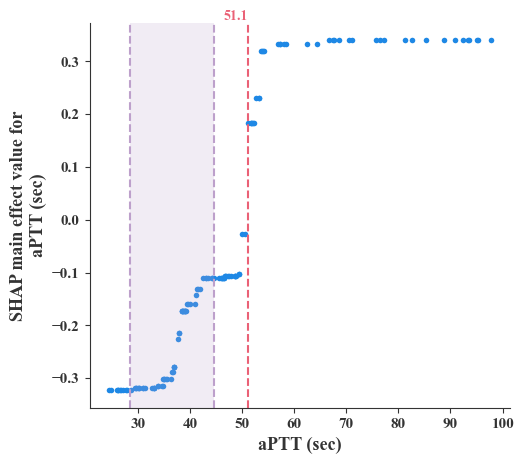

In [20]:
# Correctly extract lower and upper bounds
bounds = RI_dict[feature].split('-')
lower_bound = float(bounds[0])
upper_bound = float(bounds[1])

fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_inter_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_interaction_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/re30/feature_list_Display_name thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)

plt.figure(figsize=(10, 6)) 
shap.dependence_plot((col_dict[feature], col_dict[feature]), shap_inter_values, fore_data, show=False, feature_names=display_col, interaction_index=None)
plt.axvline(x=51.1, color='#EA6176', linestyle='--')
plt.text(51.1, plt.gca().get_ylim()[1], '51.1', color='#EA6176', horizontalalignment='right', verticalalignment='bottom')

plt.subplots_adjust(left=0.2, right=0.9) 
plt.axvline(x=lower_bound, color='#BDA0CB', linestyle='--')
plt.axvline(x=upper_bound, color='#BDA0CB', linestyle='--')
plt.axvspan(lower_bound, upper_bound, color='#BDA0CB', alpha=0.2, lw=0)
# 현재 그림을 TIFF 파일로 저장
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/RI PDP plot - '+ feature +'.tiff', format='tiff', dpi=300)
plt.show()

### SHAP interaction plot

In [44]:
model_name = 're14'
feature ='Na, Low'

<Figure size 1000x600 with 0 Axes>

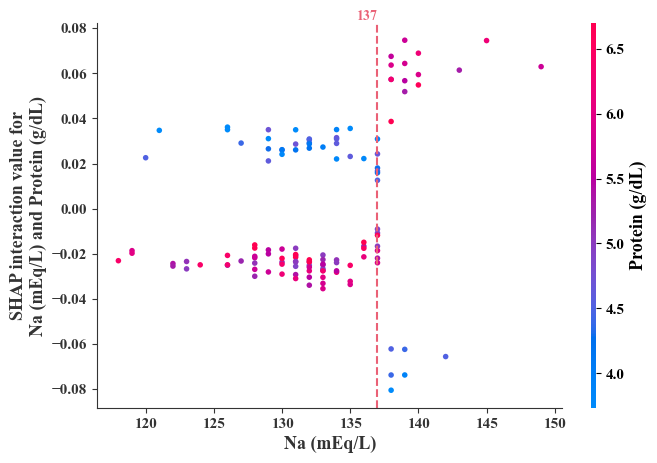

In [49]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_inter_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_interaction_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/re30/feature_list_Display_name Thesis 2.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)
plt.figure(figsize=(10, 6))

plt.subplots_adjust(left=0.2, right=0.9) 

shap.dependence_plot((col_dict[feature], col_dict['protein']), shap_inter_values, fore_data, feature_names=display_col, show=False)
plt.axvline(x=137, color='#EA6176', linestyle='--')
plt.text(137, plt.gca().get_ylim()[1], '137', color='#EA6176', horizontalalignment='right', verticalalignment='bottom')

plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/SHAP interaction plot-' + feature + '.tiff', format='tiff', dpi=300)
plt.show()

### SHAP individualized plot

In [307]:
model_name = 'after30'
idx = 30

Probability: 0.9


<Figure size 1200x1400 with 0 Axes>

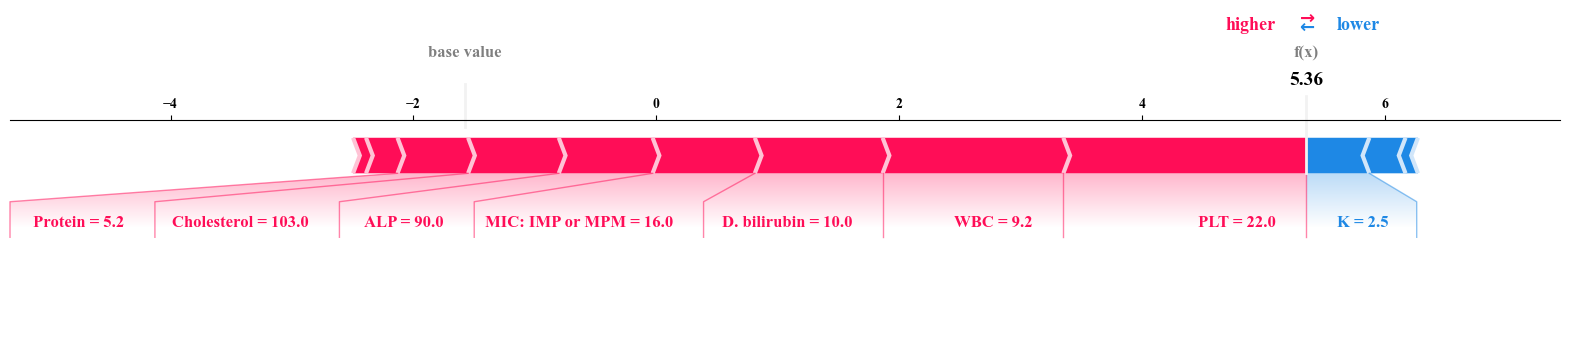

<Figure size 1200x1400 with 0 Axes>

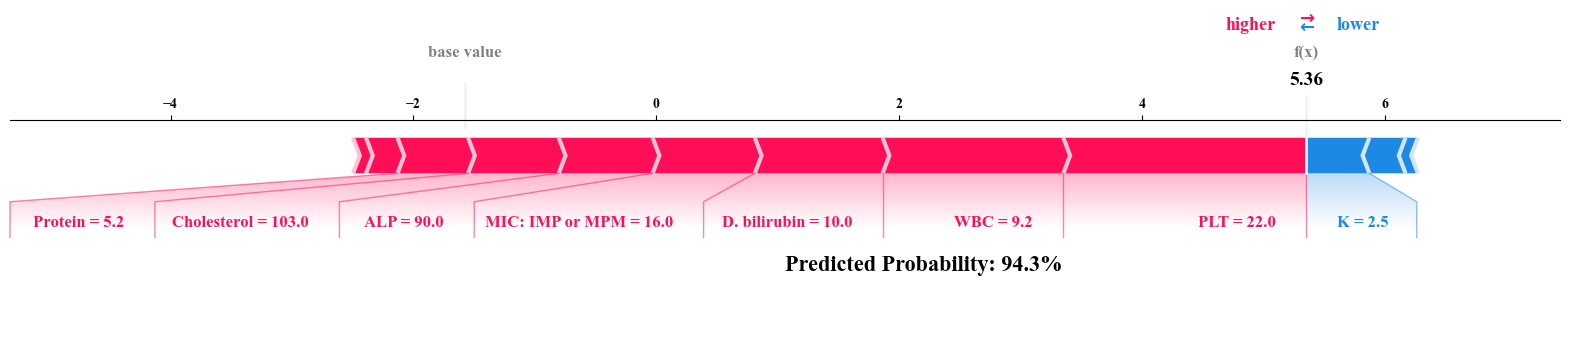

In [308]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/feature_list_Display_name after30.xlsx')
model = pickle.load(open('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/model.pickle.dat', "rb"))
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'short_name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))
explainer = shap.TreeExplainer(model)
plt.figure(figsize=(12, 14))
shap.force_plot(explainer.expected_value, shap_values[idx,:], fore_data.iloc[idx,:], matplotlib=True, feature_names=fore_data.columns.tolist(), show=False, text_rotation=0)

log_odds = model.predict(fore_data.iloc[[idx]], output_margin=True)
probability = 1 / (1 + np.exp(-log_odds))
print(f"Probability: {probability[0]:.1f}")


plt.figure(figsize=(12, 14))
shap.force_plot(explainer.expected_value, shap_values[idx,:], fore_data.iloc[idx,:], matplotlib=True, feature_names=fore_data.columns.tolist(), show=False, text_rotation=0)
plt.text(0.5, 0.35, f'Predicted Probability: {probability[0] * 100:.1f}%', fontsize=16, transform=plt.gca().transAxes)
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/BSIscore_patient-.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()


Basic decision plot features

In [309]:
model_name = 'after30'
idx = 30

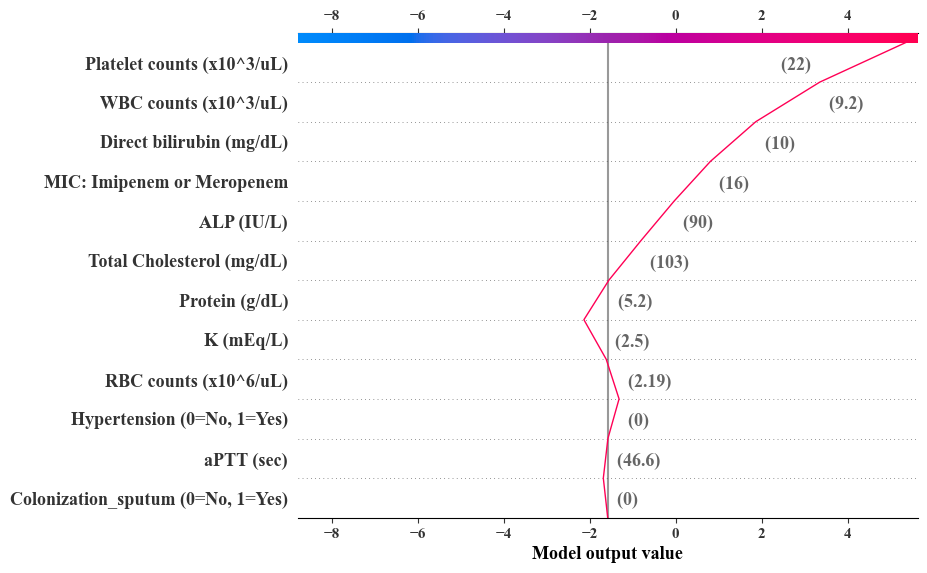

In [310]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/feature_list_Display_name after30.xlsx')
model = pickle.load(open('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/model.pickle.dat', "rb"))
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)
explainer = shap.TreeExplainer(model)


plt.figure(figsize=(12, 14))
shap.decision_plot(explainer.expected_value,shap_values[idx,:], fore_data.iloc[idx,:], feature_names=display_col, show=False)


plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/dicisionplot_patient.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()


In [81]:
fore_data = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/fore_data.xlsx')
shap_values = np.load('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/shap_values.npy')
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/feature_list_Display_name Score30.xlsx')
model = pickle.load(open('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/model.pickle.dat', "rb"))
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

fore_data = fore_data.rename(columns=col_dict)
explainer = shap.TreeExplainer(model)


shap.plots.waterfall(shap_values[idx], max_display=14)


plt.figure(figsize=(12, 14))
shap.plots.waterfall(shap_values[idx], max_display=14, feature_names=display_col)
plt.savefig('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/'+model_name+'/waterfall_plot_idx70.tiff', format='tiff', dpi=300, bbox_inches='tight')


TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.